This notebook will be used to create the plots that will do daily comparisons of the model to ONC VENUS nodes.

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import numpy as np
from IPython.display import display, Math, Latex
import datetime
import pandas as pd
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import (viz_tools, tidetools, nc_tools, tidetools)
from salishsea_tools.nowcast import (research_VENUS, analyze, figures)

%matplotlib inline

In [2]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color': 'white'}

In [4]:
grid_B = nc.Dataset('/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
Y = grid_B.variables['nav_lat'][:]
X = grid_B.variables['nav_lon'][:]
bathy = grid_B.variables['Bathymetry'][:,:]

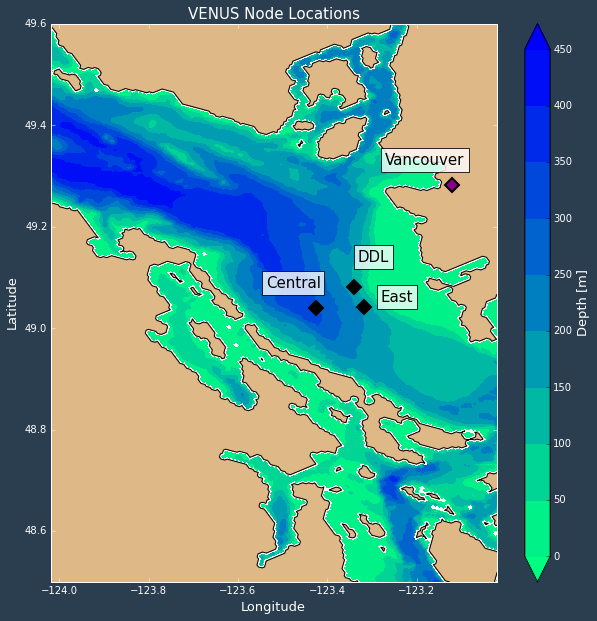

In [5]:
fig = research_VENUS.VENUS_location(grid_B)

What day do we want to look at?
    * The time must be 00:45:00 because that is when the second available value for any day. The first time available is at 00:15:00 but in python the matlab time translate to a value with alot of decimals.

In [6]:
yesterday = datetime.datetime(2015, 10, 20, 0, 45, 0)
yesterdate = yesterday.strftime('%d%b%y').lower()

## Load the grids
* Model values

In [7]:
filC = '/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_central_gridded.nc'.format(yesterdate)
filE = '/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_east_gridded.nc'.format(yesterdate)
filD = '/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/VENUS_delta_gridded.nc'.format(yesterdate) #change to delta when available

filet=glob.glob('/data/dlatorne/MEOPAR/SalishSea/nowcast/{}/SalishSea_1h_*_grid_T.nc'.format(yesterdate))[0]

grid_c = nc.Dataset(filC)
grid_e = nc.Dataset(filE)
grid_t = nc.Dataset(filet)
grid_d = nc.Dataset(filD)

* Observational values

In [9]:
#Delta location
Lat = 49.08071666666667
Lon = -123.34006166666667
i, j  = tidetools.find_closest_model_point(Lon, Lat, X, Y, bathy, lon_tol = 0.006, lat_tol=0.003)
print(i, j)

425 284


In [10]:
grid_oc = sio.loadmat('/ocean/dlatorne/MEOPAR/ONC_ADCP/ADCPcentral.mat')
grid_oe = sio.loadmat('/ocean/dlatorne/MEOPAR/ONC_ADCP/ADCPeast.mat')
grid_od = sio.loadmat('/ocean/dlatorne/MEOPAR/ONC_ADCP/ADCPddl.mat')

# Prepare velocities

## Contour plot of velocities

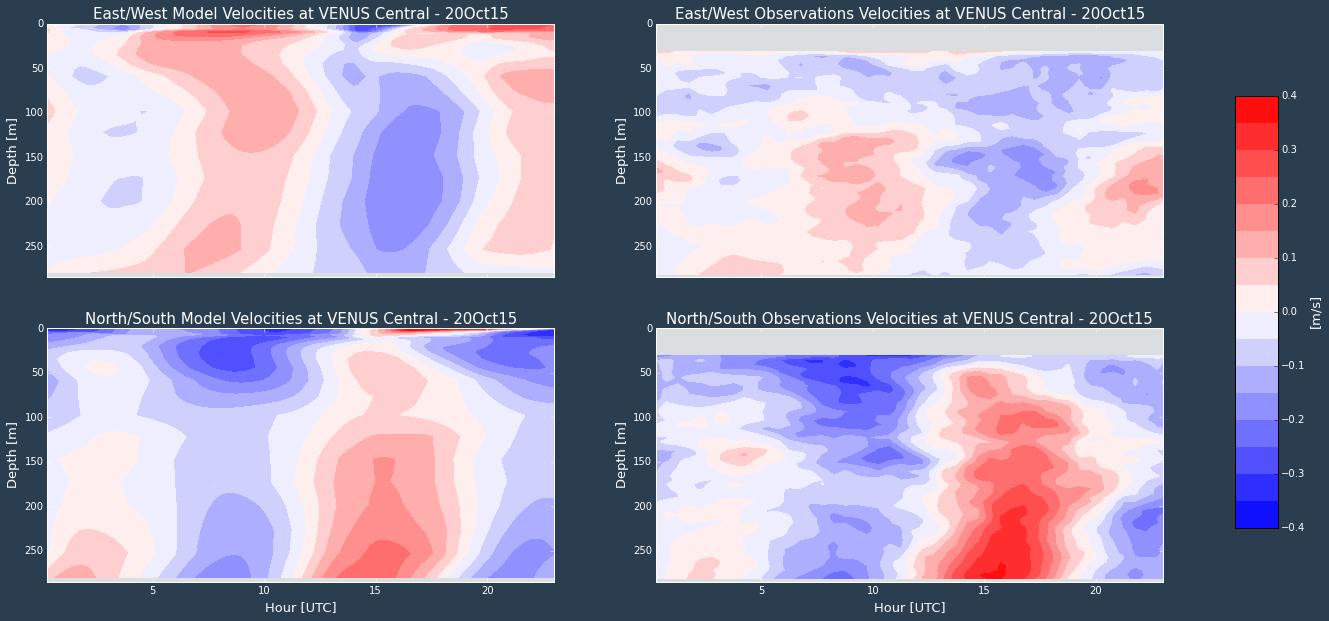

In [11]:
fig1 = research_VENUS.plotADCP(grid_c, grid_oc, yesterday, 'Central', [0,285])

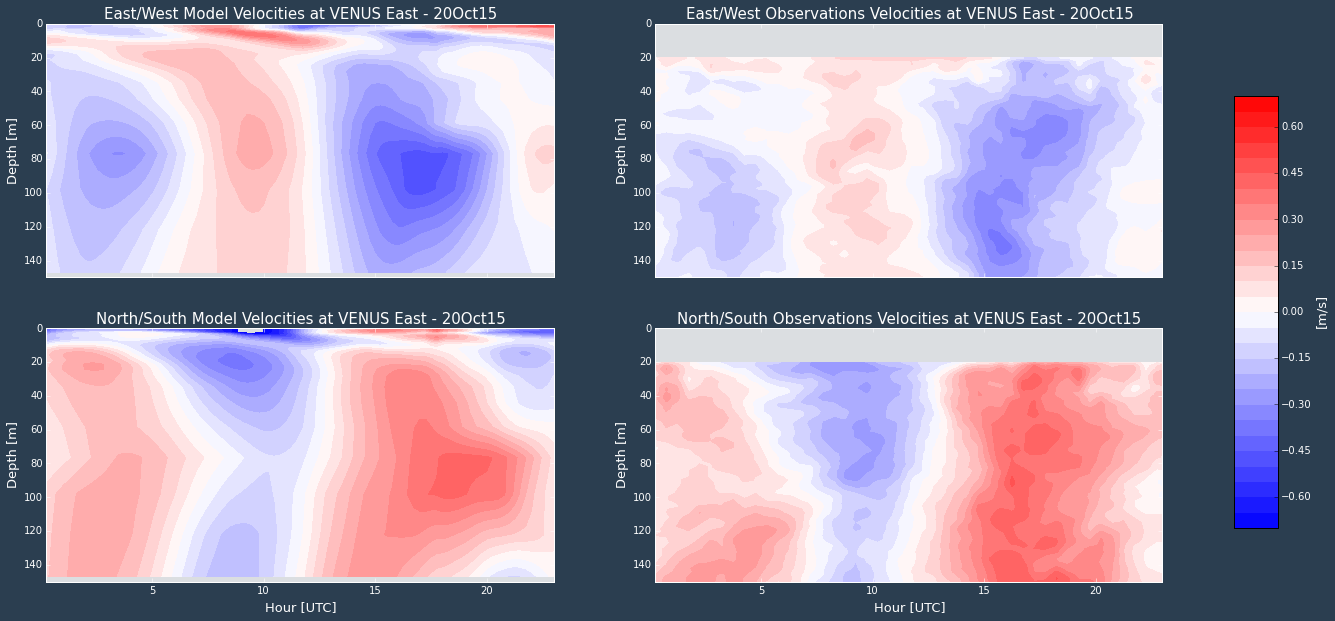

In [12]:
fig1 = research_VENUS.plotADCP(grid_e, grid_oe, yesterday, 'East', [0,150])

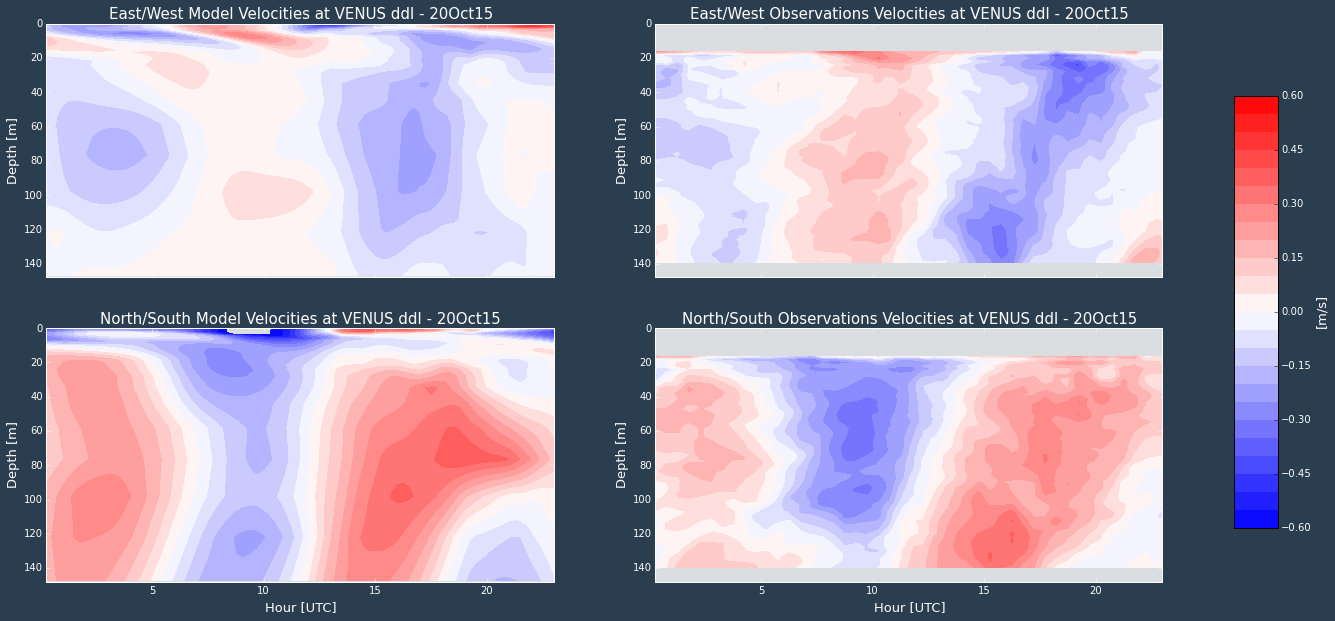

In [13]:
fig1 = research_VENUS.plotADCP(grid_d, grid_od, yesterday, 'ddl', [0,148])

## Depth averaged velcities

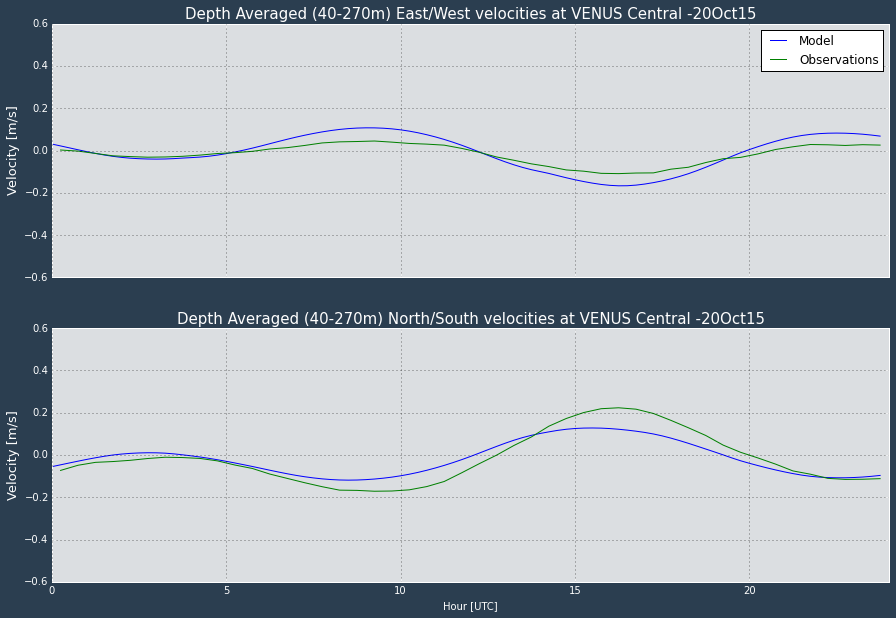

In [14]:
fig = research_VENUS.plotdepavADCP(grid_c, grid_oc, yesterday, 'Central')

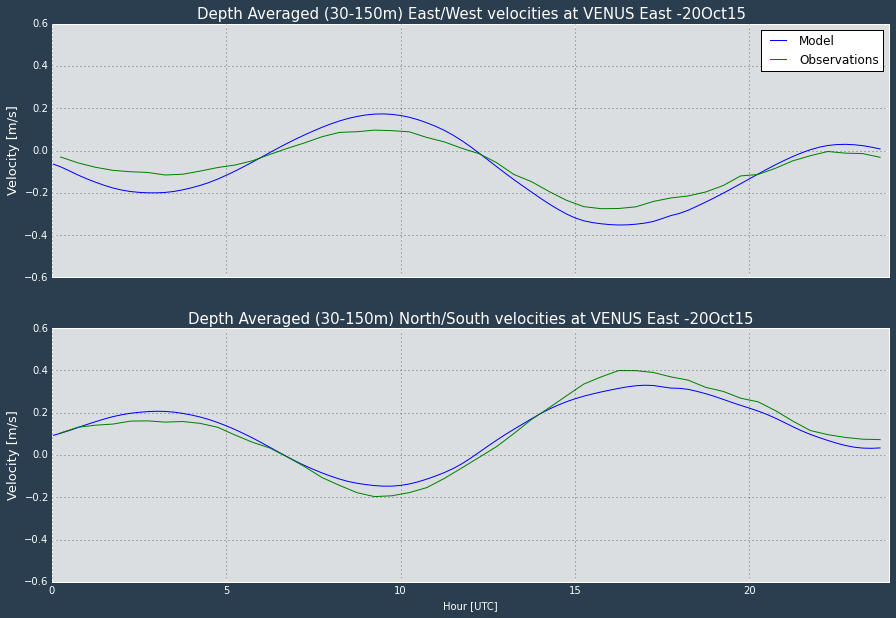

In [15]:
fig = research_VENUS.plotdepavADCP(grid_e, grid_oe, yesterday, 'East')

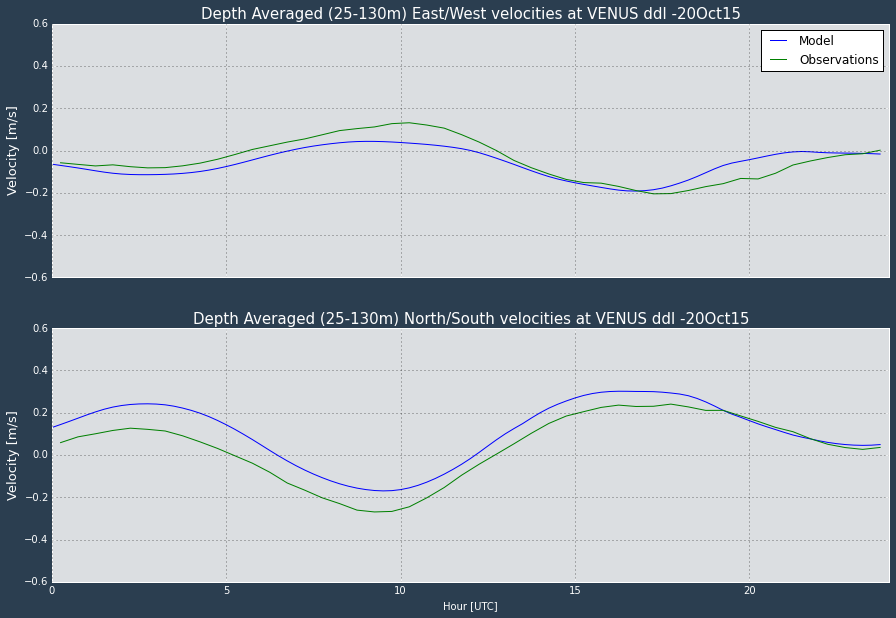

In [16]:
fig = research_VENUS.plotdepavADCP(grid_d, grid_od, yesterday, 'ddl')

## Time averaged velocities

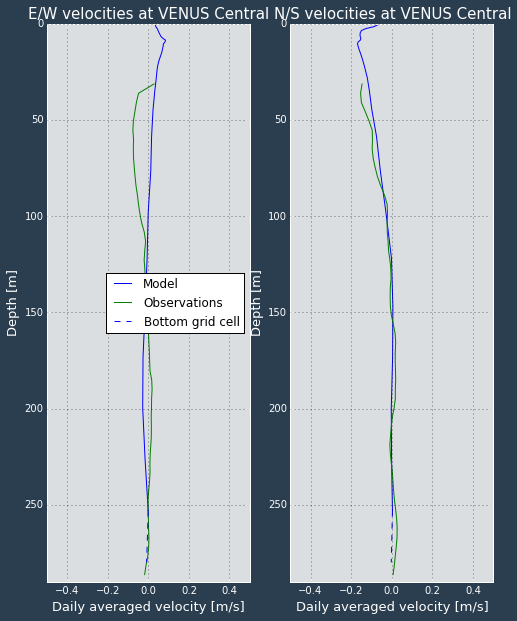

In [17]:
fig = research_VENUS.plottimeavADCP(grid_c, grid_oc, yesterday, 'Central')

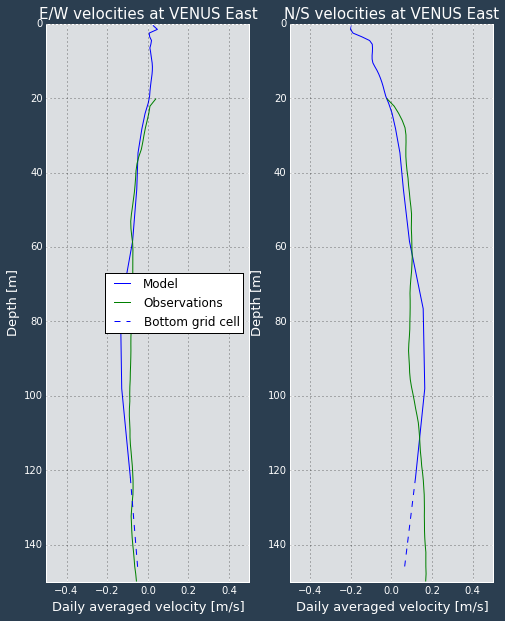

In [18]:
fig = research_VENUS.plottimeavADCP(grid_e, grid_oe, yesterday, 'East')

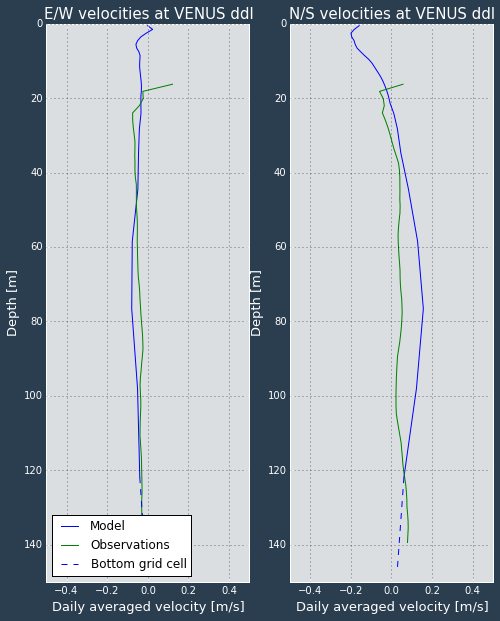

In [19]:
fig = research_VENUS.plottimeavADCP(grid_d, grid_od, yesterday, 'ddl')